In [57]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF 
import xarray as xr
import matplotlib.pyplot as plt

from renewable_data_load import *

## Memory-Efficient SEI Functions with apply_ufunc

These functions combine the best of both approaches:
1. Dynamic window extraction (no redundant storage)
2. Vectorized computation with automatic parallelization via `apply_ufunc`

In [ ]:
def extract_window_samples(ds_reference, doy, window_size=60):
    """
    Extract window samples for a single day-of-year from reference period.
    
    Parameters
    ----------
    ds_reference : xarray.Dataset
        Reference period data with time dimension
    doy : int
        Day-of-year to extract window for (1-365)
    window_size : int
        Window size in days (centered on doy)
        
    Returns
    -------
    window_data : xarray.DataArray
        Window samples with dimensions (sample, y, x)
    """
    half_window = window_size // 2
    
    # Handle circular day-of-year for window edges
    doy_min = doy - half_window
    doy_max = doy + half_window
    
    # Extract time indices where dayofyear falls in window
    reference_doy = ds_reference.time.dt.dayofyear
    
    if doy_min < 1:
        # Wrap around year boundary (e.g., doy=5, window includes doy=340-365 and 1-35)
        mask = (reference_doy >= (365 + doy_min)) | (reference_doy <= doy_max)
    elif doy_max > 365:
        # Wrap around year boundary (e.g., doy=361, window includes 331-365 and 1-26)
        mask = (reference_doy >= doy_min) | (reference_doy <= (doy_max - 365))
    else:
        # Normal case - no wrap-around
        mask = (reference_doy >= doy_min) & (reference_doy <= doy_max)
    
    # Extract and flatten time dimension to 'sample'
    window_data = ds_reference.where(mask, drop=True)
    window_data = window_data.stack(sample=['time'])
    
    return window_data

def compute_sei_vectorized(reference_samples, future_value):
    """
    Vectorized SEI computation for a single spatial point.
    
    This function is designed to work with xr.apply_ufunc and operates on numpy arrays.
    
    Parameters
    ----------
    reference_samples : np.ndarray
        1D array of historical samples from the window
    future_value : float or np.ndarray
        Future value(s) to compute SEI for
        
    Returns
    -------
    sei : float or np.ndarray
        Standardized energy index (Z-score)
    """
    # Remove NaN values
    valid_samples = reference_samples[~np.isnan(reference_samples)]
    
    if len(valid_samples) == 0:
        # No valid data - return NaN
        return np.full_like(future_value, np.nan, dtype=np.float32)
    
    # Fit ECDF to historical distribution
    ecdf_func = ECDF(valid_samples)
    
    # Compute probabilities
    fn_x = ecdf_func(future_value)
    
    # Apply smoothing: (n * F_n(x) + 1) / (n + 2)
    n = len(valid_samples)
    f_x_rescaled = (n * fn_x + 1) / (n + 2)
    
    # Convert to Z-scores
    sei = norm.ppf(f_x_rescaled)
    
    return sei.astype(np.float32)


def compute_sei_for_doy_parallel(ds_reference, ds_doy, doy, window_size=60):
    """
    Compute SEI for a single day-of-year using apply_ufunc for parallelization.
    
    Parameters
    ----------
    ds_reference : xarray.Dataset
        Reference period data with time dimension for ECDF fitting
    ds_doy : xarray.DataArray
        Future data for this specific day-of-year (year, y, x)
    doy : int
        Day-of-year to process (1-365)
    window_size : int
        Window size in days (centered on doy)
        
    Returns
    -------
    sei : xarray.DataArray
        Standardized energy index (year, y, x)
    """
    # Extract window samples for this DOY
    window_samples = extract_window_samples(ds_reference, doy, window_size)
    
    # Use apply_ufunc for vectorized, parallelized computation
    sei = xr.apply_ufunc(
        compute_sei_vectorized,
        window_samples,        # (sample, y, x)
        ds_doy,         # (year, y, x)
        input_core_dims=[['sample'], []],  # 'sample' is core dim for ECDF, none for future values
        output_core_dims=[[]],              # Output has no additional core dims
        vectorize=True,                     # Vectorize over (y, x, year)
        dask='parallelized',                # Enable parallel execution with dask
        output_dtypes=[np.float32],         # Output data type
        exclude_dims=set(('sample',)),      # 'sample' dimension consumed in function
        dask_gufunc_kwargs={'allow_rechunk': True}  # Allow rechunking for efficiency
    )
    
    sei.name = 'sei'
    return sei

## Load Data

In [ ]:
resource = "pv"
module = "distributed"
domain = "d03"
variable = "gen"
frequency = "day"
simulation = "ec-earth3"
scenario = "historical"
reference_gwl = 0.8

window_size = 60

ren_ds = get_ren_data_concat(resource, module, domain, variable, frequency, simulation)

#### SUBSET FOR TESTING ####
ren_ds = ren_ds.isel(y=slice(222,226), x=slice(53,57)) # Small slice for testing
#ren_ds = ren_ds.isel(y=297, x=88)

# Get bounds for reference GWL period
WRF_sim_name = sim_name_dict[simulation]
model = WRF_sim_name.split("_")[1]
ensemble_member = WRF_sim_name.split("_")[2]
start_year, end_year = get_gwl_crossing_period(model, ensemble_member, reference_gwl)

# Extract reference periods
ds_reference = ren_ds.sel(time=slice(f"{start_year}", f"{end_year}"))

## Reshape Future Data to (dayofyear, year, y, x)
ds_doy = ren_ds.copy(deep=True)

# Add temporal coordinates
ds_doy['dayofyear'] = ds_doy.time.dt.dayofyear
ds_doy['year'] = ds_doy.time.dt.year

# Reshape: time -> (dayofyear, year)
ds_doy = ds_doy.drop_vars("time").set_index(time=['dayofyear','year']).unstack()

# Remove 2014 if present (GCM artifact)
if simulation != "ERA5" and 2014 in ds_doy.year:
    ds_doy = ds_doy.drop_sel(year=2014)

print(f"Reshaped future data: {ds_doy.sizes}")


## Compute SEI for Each Day-of-Year

# List to collect SEI for each day-of-year
sei_list = []
gen_list = []

# Process each day-of-year
for doy in range(1, 366):
    if doy % 50 == 0:
        print(f"Processing day {doy}/365...")
    
    # Get future generation data for this DOY
    future_doy_data = ds_doy.sel(dayofyear=doy)
    
    # Compute SEI for this DOY using parallelized apply_ufunc
    sei_doy = compute_sei_for_doy_parallel(ds_reference, future_doy_data, doy, window_size)
    
    # Add dayofyear coordinate
    sei_doy = sei_doy.expand_dims(dayofyear=[doy])
    gen_doy = future_doy_data.expand_dims(dayofyear=[doy])
    
    sei_list.append(sei_doy)
    gen_list.append(gen_doy)

print("Concatenating results...")

# Concatenate all days-of-year
sei_full = xr.concat(sei_list, dim='dayofyear')
gen_full = xr.concat(gen_list, dim='dayofyear')

# Merge into final dataset
drought_ds = xr.Dataset({
    'gen': gen_full,
    'sei': sei_full
})

drought_ds = drought_ds.compute()
##################
if simulation != "ERA5":
    synth = np.zeros(shape=[365, 1])
    synth[:, :] = np.nan
    fill_data = xr.Dataset(
        data_vars={
            "gen": (['dayofyear', 'year'], synth),
            "sei": (['dayofyear', 'year'], synth)
        },
        coords={
            "year": [2014], 
            "dayofyear": np.arange(1, 366, 1)
        }
    )
    drought_ds = xr.merge([fill_data, drought_ds])
#####################


#### SAVE to zarr

output_path = f"../data/SEI/{resource}_{module}_{domain}_{variable}_daily_sei_{simulation}_{scenario}_gwl{reference_gwl}.zarr"

# Compute the data to remove dask/encoding metadata and load into memory
print("Computing final dataset...")


# Remove encoding to avoid zarr version conflicts
for var in drought_ds.data_vars:
    if 'encoding' in drought_ds[var].attrs:
        del drought_ds[var].attrs['encoding']
    drought_ds[var].encoding = {}

for coord in drought_ds.coords:
    if 'encoding' in drought_ds[coord].attrs:
        del drought_ds[coord].attrs['encoding']
    drought_ds[coord].encoding = {}

# Add metadata
drought_ds.attrs['title'] = f'Standardized Energy Index - {resource} {module}'
drought_ds.attrs['simulation'] = simulation
drought_ds.attrs['scenario'] = scenario
drought_ds.attrs['reference_gwl'] = reference_gwl
drought_ds.attrs['reference_period'] = f"{start_year}-{end_year}"
drought_ds.attrs['window_size_days'] = window_size
drought_ds.attrs['method'] = 'memory-efficient dynamic window extraction with apply_ufunc parallelization'

print(f"Saving to: {output_path}")
drought_ds.to_zarr(output_path, mode='w')
print("Save complete!")

Reshaped future data: Frozen({'y': 4, 'x': 4, 'dayofyear': 365, 'year': 118})
Processing day 50/365...
Processing day 50/365...
Processing day 100/365...
Processing day 100/365...
Processing day 150/365...
Processing day 150/365...
Processing day 200/365...
Processing day 200/365...
Processing day 250/365...
Processing day 250/365...
Processing day 300/365...
Processing day 300/365...
Processing day 350/365...
Concatenating results...
Processing day 350/365...
Concatenating results...
Computing final dataset...
Saving to: ../data/SEI/pv_distributed_d03_gen_daily_sei_ec-earth3_historical_gwl0.8.zarr
Save complete!
Computing final dataset...
Saving to: ../data/SEI/pv_distributed_d03_gen_daily_sei_ec-earth3_historical_gwl0.8.zarr
Save complete!


/var/folders/1w/yd54lcgx163cw02f2gzwh9880000gp/T/ipykernel_79515/3389417037.py:96: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'year' ('year',) The recommendation is to set join explicitly for this case.
  drought_ds = xr.merge([fill_data, drought_ds])
/var/folders/1w/yd54lcgx163cw02f2gzwh9880000gp/T/ipykernel_79515/3389417037.py:96: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  drought_ds = xr.merge([fill_data, drought_d

## Validation: Test at Single Location

In [15]:
test_ds = drought_ds.isel(y=0, x=0)

In [16]:
test_ds = drought_ds

## Visualization: Full Time Series at Test Location

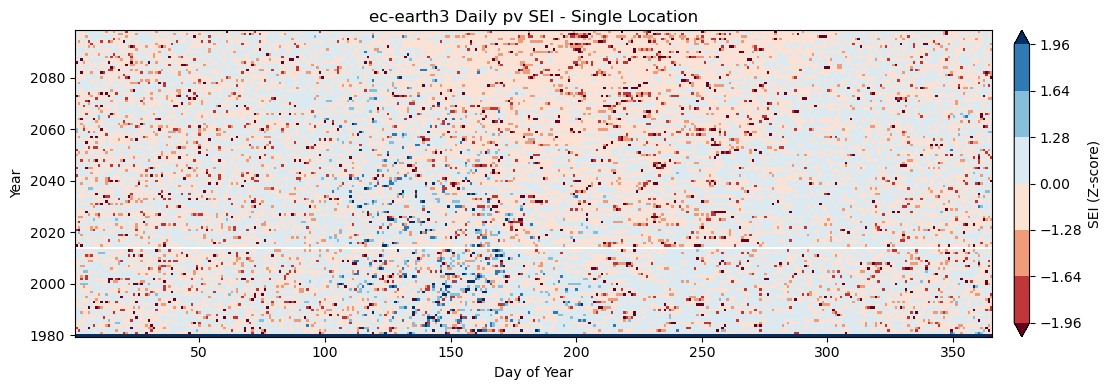

In [17]:
fig, ax = plt.subplots(figsize=(12, 4))
xr.plot.imshow(
    test_ds.sei.T, 
    ax=ax, 
    levels=[-1.96, -1.64, -1.28, 0, 1.28, 1.64, 1.96], 
    cmap="RdBu", 
    cbar_kwargs={'pad': 0.02, 'label': 'SEI (Z-score)'}
)
plt.title(f"{simulation} Daily {resource} SEI - Single Location")
plt.ylabel("Year")
plt.xlabel("Day of Year")
plt.tight_layout()
plt.show()

## Save Results to Zarr

Using zarr format for efficient chunked storage.

In [ ]:
output_path = f"../data/SEI/{resource}_{module}_{domain}_{variable}_daily_sei_{simulation}_{scenario}_gwl{reference_gwl}.zarr"

# Compute the data to remove dask/encoding metadata and load into memory
print("Computing final dataset...")
drought_ds = drought_ds.compute()

# Remove encoding to avoid zarr version conflicts
for var in drought_ds.data_vars:
    if 'encoding' in drought_ds[var].attrs:
        del drought_ds[var].attrs['encoding']
    drought_ds[var].encoding = {}

for coord in drought_ds.coords:
    if 'encoding' in drought_ds[coord].attrs:
        del drought_ds[coord].attrs['encoding']
    drought_ds[coord].encoding = {}

# Add metadata
drought_ds.attrs['title'] = f'Standardized Energy Index - {resource} {module}'
drought_ds.attrs['simulation'] = simulation
drought_ds.attrs['scenario'] = scenario
drought_ds.attrs['reference_gwl'] = reference_gwl
drought_ds.attrs['reference_period'] = f"{start_year}-{end_year}"
drought_ds.attrs['window_size_days'] = window_size
drought_ds.attrs['method'] = 'memory-efficient dynamic window extraction with apply_ufunc parallelization'

print(f"Saving to: {output_path}")
drought_ds.to_zarr(output_path, mode='w')
print("Save complete!")

Computing final dataset...
Saving to: ../data/SEI/pv_distributed_d03_gen_daily_sei_ec-earth3_historical_gwl0.8.zarr
Save complete!


/Users/work/miniconda3/envs/renewables-analysis/lib/python3.12/site-packages/zarr/api/asynchronous.py:244: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


In [18]:
import psutil
import os

def monitor_memory(label=""):
    process = psutil.Process(os.getpid())
    mem_gb = process.memory_info().rss / 1e9
    print(f"{label} Memory: {mem_gb:.2f} GB")
    return mem_gb

# Use throughout notebook
monitor_memory("Initial")
# ... your code ...
monitor_memory("After compute")

Initial Memory: 0.13 GB
After compute Memory: 0.13 GB


0.1294336

In [58]:
test = xr.open_mfdataset('../data/SEI/pv_distributed_d03_gen_daily_sei_ec-earth3_historical_gwl0.8_chunk_*.nc')

/var/folders/1w/yd54lcgx163cw02f2gzwh9880000gp/T/ipykernel_79515/2075540937.py:1: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'y' ('y',) The recommendation is to set join explicitly for this case.
  test = xr.open_mfdataset('../data/SEI/pv_distributed_d03_gen_daily_sei_ec-earth3_historical_gwl0.8_chunk_*.nc')


In [59]:
test

<xarray.Dataset> Size: 33GB
Dimensions:            (dayofyear: 365, year: 119, y: 210, x: 223)
Coordinates:
  * dayofyear          (dayofyear) int32 1kB 1 2 3 4 5 6 ... 361 362 363 364 365
  * year               (year) int32 476B 1980 1981 1982 1983 ... 2096 2097 2098
  * y                  (y) float64 2kB 4.849e+05 4.879e+05 ... 1.112e+06
  * x                  (x) float64 2kB -4.305e+06 -4.302e+06 ... -3.639e+06
    landmask           (y, x) float32 187kB dask.array<chunksize=(10, 10), meta=np.ndarray>
    lat                (y, x) float32 187kB dask.array<chunksize=(10, 10), meta=np.ndarray>
    lon                (y, x) float32 187kB dask.array<chunksize=(10, 10), meta=np.ndarray>
    Lambert_Conformal  int32 4B 1
Data variables:
    gen                (dayofyear, year, y, x) float64 16GB dask.array<chunksize=(365, 119, 10, 10), meta=np.ndarray>
    sei                (dayofyear, year, y, x) float64 16GB dask.array<chunksize=(365, 119, 10, 10), meta=np.ndarray>
Attributes: (12/13)
    chunk_x_idx:       0
    chunk_y_idx:       0
    title:             Standardized Energy Index - pv distributed
    simulation:        ec-earth3
    scenario:          historical
    reference_gwl:     0.8
    ...                ...
    window_size_days:  60
    method:            memory-efficient dynamic window extraction with apply_...
    y_start:           0
    y_end:             10
    x_start:           0
    x_end:             10

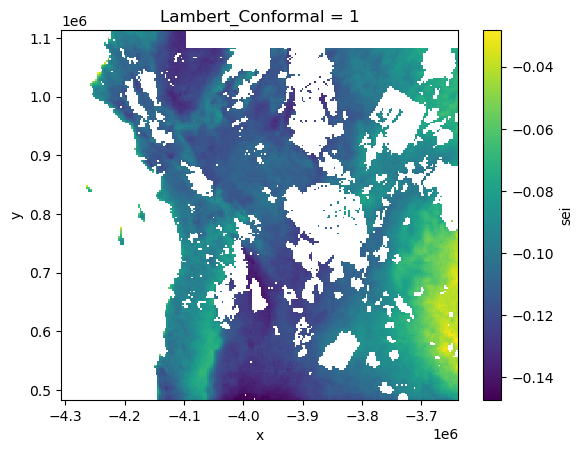

In [60]:
test.mean(['dayofyear','year']).sei.plot()

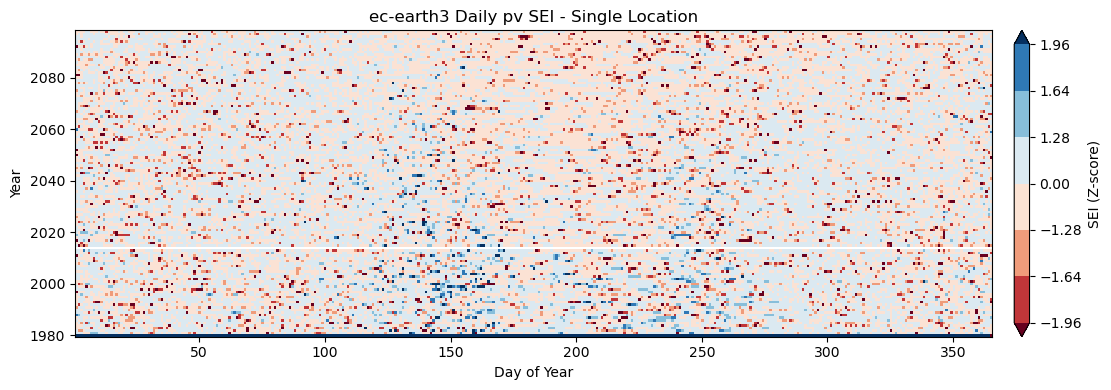

In [49]:
fig, ax = plt.subplots(figsize=(12, 4))
xr.plot.imshow(
    test.isel(x=80,y=40).sei.T, 
    ax=ax, 
    levels=[-1.96, -1.64, -1.28, 0, 1.28, 1.64, 1.96], 
    cmap="RdBu", 
    cbar_kwargs={'pad': 0.02, 'label': 'SEI (Z-score)'}
)
plt.title(f"{simulation} Daily {resource} SEI - Single Location")
plt.ylabel("Year")
plt.xlabel("Day of Year")
plt.tight_layout()
plt.show()